# Graph net for link prediction

Question: does including the neighborhood provide a benefit over the pairwise classification?

In [14]:
import numpy as np
import torch
import sys

import torch.nn as nn
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR

from torch.utils.data import random_split
from torch_geometric.loader import DataLoader

import torch_geometric.utils as geou

import torch_geometric.nn as gnn

from reco.model import EdgeConvBlock, DynamicEdgeConvBlock

from reco.training import precision_recall_curve, roc_auc
from reco.loss import QualityFocalLoss
from reco.datasetPU import TracksterGraph


ds_name = "MultiParticle"

data_root = "data"
raw_dir = f"/Users/ecuba/data/{ds_name}"

data_root = "/mnt/ceph/users/ecuba/processed"
raw_dir = f"/mnt/ceph/users/ecuba/{ds_name}"

In [15]:
# CUDA Setup
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [35]:
ds = TracksterGraph(
    ds_name,
    data_root,
    raw_dir,
    N_FILES=50,
    pileup=False,
    radius=30,
    bigT_e_th=10,
    link_prediction=True,
)
ds

TracksterGraph(graphs=5000, nodes=1272368, radius=30, bigT_e_th=10, lp)

In [36]:
# sum(ds.data.y > 0.5) / len(ds.data.y)

In [37]:
len(ds.data.y)

13283054

In [38]:
ds_size = len(ds)
test_set_size = ds_size // 20
train_set_size = ds_size - test_set_size
train_set, test_set = random_split(ds, [train_set_size, test_set_size])
print(f"Train graphs: {len(train_set)}, Test graphs: {len(test_set)}, total: {ds_size}")

train_dl = DataLoader(train_set, batch_size=8, shuffle=True, drop_last=True)
test_dl = DataLoader(test_set, batch_size=8, shuffle=True, drop_last=True)

Train graphs: 4750, Test graphs: 250, total: 5000


In [39]:
class LinkPredictionNet(nn.Module):
    def __init__(self, input_dim, output_dim=1, dropout=0.2):
        super(LinkPredictionNet, self).__init__()
        self.norm = gnn.LayerNorm(input_dim)
        
        hdim1 = 64
        hdim2 = 64
        hdim3 = 64
        hdim_fc = 256

        self.edgeconv1 = DynamicEdgeConvBlock(input_dim, hdim1, k=8)
        self.edgeconv2 = DynamicEdgeConvBlock(hdim1, hdim2, k=8)
        self.edgeconv3 = DynamicEdgeConvBlock(hdim2, hdim3, k=8)
        
        # Edge features from node embeddings for classification        
        self.nodenetwork = nn.Sequential(
            nn.Linear(2 * hdim3, hdim_fc),
            nn.Sigmoid(),
            nn.Dropout(dropout),
            nn.Linear(hdim_fc, output_dim),
        )

    def forward(self, X, edge_index, batch=None):
        
        #(prepared_edges, _) = geou.add_self_loops(edge_index)  
        #undirected_index = geou.to_undirected(prepared_edges)

        H0 = self.norm(X, batch)
        H1 = self.edgeconv1(H0, batch=batch)
        H2 = self.edgeconv2(H1, batch=batch)
        H3 = self.edgeconv3(H2, batch=batch)
        
        src, dst = edge_index
        edges = torch.cat([H3[src], H3[dst]], dim=-1)
        return self.nodenetwork(edges).squeeze(-1)

In [40]:
def train_link_prediction(model, device, optimizer, loss_func, train_dl):
    train_loss = []
    model.train()

    for data in train_dl:
        data = data.to(device)
        optimizer.zero_grad()

        seg_pred = model(data.x, data.edge_index, batch=data.batch)        
        loss = loss_func(seg_pred, data.y)
        
        loss.backward()
        
        optimizer.step()
        train_loss.append(loss.item())

    return np.mean(train_loss)

In [41]:
@torch.no_grad()
def test_link_prediction(model, device, loss_func, test_dl):
    test_loss = []
    model.eval()
    for data in test_dl:
        data = data.to(device)
        seg_pred = model(data.x, data.edge_index, data.batch)
        loss = loss_func(seg_pred, data.y)
        test_loss.append(loss.item())

    return np.mean(test_loss)

In [42]:
model = LinkPredictionNet(input_dim=ds.data.x.shape[1])
epochs = 101
model_path = f"models/LinkPredictionNet.PnetL.ns.{epochs}e-{ds_name}.r{ds.RADIUS}.e{ds.bigT_e_th}.f{ds.N_FILES}.pt"

In [43]:
# %%script echo skipping
# alpha - percentage of negative edges
loss_func = QualityFocalLoss()

model = model.to(device)
optimizer = Adam(model.parameters(), lr=1e-3)
scheduler = CosineAnnealingLR(optimizer, epochs, eta_min=1e-5)

for epoch in range(epochs):

    train_loss = train_link_prediction(
        model,
        device,
        optimizer,
        loss_func,
        train_dl
    )
    
    scheduler.step()

    if epoch % 5 == 0:
        test_loss = test_link_prediction(model, device, loss_func, test_dl)
        print(
            f"Epoch {epoch}:\t train loss: {train_loss:.3f}\t validation loss: {test_loss:.3f}",
            file=sys.stderr
        )
        
torch.save(model.state_dict(), model_path)
print(model_path)

Epoch 0:	 train loss: 1581.485	 validation loss: 1456.502
Epoch 5:	 train loss: 1104.280	 validation loss: 1083.859
Epoch 10:	 train loss: 836.785	 validation loss: 815.774
Epoch 15:	 train loss: 793.508	 validation loss: 763.746
Epoch 20:	 train loss: 766.626	 validation loss: 734.025
Epoch 25:	 train loss: 748.645	 validation loss: 708.586
Epoch 30:	 train loss: 730.224	 validation loss: 688.772
Epoch 35:	 train loss: 718.553	 validation loss: 687.950
Epoch 40:	 train loss: 709.739	 validation loss: 668.761
Epoch 45:	 train loss: 701.296	 validation loss: 699.374
Epoch 50:	 train loss: 693.809	 validation loss: 660.919
Epoch 55:	 train loss: 688.256	 validation loss: 656.794
Epoch 60:	 train loss: 683.724	 validation loss: 648.978
Epoch 65:	 train loss: 676.459	 validation loss: 640.425
Epoch 70:	 train loss: 671.924	 validation loss: 636.738
Epoch 75:	 train loss: 669.631	 validation loss: 634.486
Epoch 80:	 train loss: 667.136	 validation loss: 635.332
Epoch 85:	 train loss: 664.51

models/LinkPredictionNet.PnetL.ns.101e-MultiParticle.r30.e10.f50.pt


Epoch 100:	 train loss: 660.537	 validation loss: 631.087


In [44]:
%%script echo skipping
model.load_state_dict(torch.load(
    model_path,
    map_location=device
))
model = model.to(device)

skipping


0.9432493143773512


Future exception was never retrieved
future: <Future finished exception=BrokenPipeError(32, 'Broken pipe')>
Traceback (most recent call last):
  File "/mnt/sw/nix/store/z6v265ivx5w6xbajay41vdfc0la8gla5-python-3.9.12-view/lib/python3.9/asyncio/unix_events.py", line 665, in write
    n = os.write(self._fileno, data)
BrokenPipeError: [Errno 32] Broken pipe


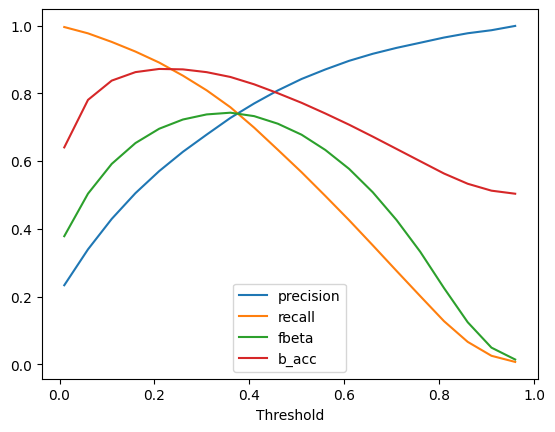

TP: 89729, TN: 505115, FP: 33638, FN: 28519
TH: 0.36 precision: 0.727 recall: 0.759 fbeta: 0.743 b_acc: 0.848


In [45]:
#%%script echo skipping
print(roc_auc(model, device, test_dl))
precision_recall_curve(model, device, test_dl, focus_metric="fbeta", beta=1, step=5, truth_threshold=0.5)

- 51 epochs: 91.9
- 100 epochs: 92.6

## Eval

In [46]:
import uproot
import matplotlib.pyplot as plt
import numpy as np
from reco.data import get_event_data
from reco.evaluation import model_evaluation
from reco.dummy import DummyPleaser

file_name = f"{raw_dir}/new_ntuples_15163313_1.root"
cluster_data, trackster_data, simtrackster_data, assoc_data = get_event_data(file_name)

In [47]:
r_ranges = r_ranges = [5, 10, 20, 30]
results = []

max_events = 20
clue3D_F = []
target_F = []
naive_reco_F = []
model_reco_F = []
for r in r_ranges:
    print(f"--- Radius threshold: {r} ---")
    result = model_evaluation(
        cluster_data,
        trackster_data,
        simtrackster_data,
        assoc_data,
        model.to("cpu"),
        decision_th=0.5,
        radius=r,
        max_events=max_events,
        bigT_e_th=10,
        pileup=False,
        graph=True,
        link_prediction=True,
    )
    clue3D_F.append(np.sum(np.array(result["clue3d_to_sim"])[:,2]) / max_events)
    target_F.append(np.sum(np.array(result["target_to_sim"])[:,2]) / max_events)
    model_reco_F.append(np.sum(np.array(result["reco_to_sim"])[:,2]) / max_events)

--- Radius threshold: 5 ---
Event 0:
	clue3d_to_sim:	P: 0.991 R: 0.148 F: 0.464
	target_to_sim:	P: 0.972 R: 0.166 F: 0.494
	reco_to_sim:	P: 0.988 R: 0.170 F: 0.504
	|S| = 10 |T| = 57 |R| = 55
Event 1:
	clue3d_to_sim:	P: 0.956 R: 0.093 F: 0.335
	target_to_sim:	P: 0.922 R: 0.174 F: 0.495
	reco_to_sim:	P: 0.951 R: 0.139 F: 0.438
	|S| = 10 |T| = 72 |R| = 91
Event 2:
	clue3d_to_sim:	P: 0.991 R: 0.189 F: 0.536
	target_to_sim:	P: 0.990 R: 0.228 F: 0.593
	reco_to_sim:	P: 0.990 R: 0.224 F: 0.587
	|S| = 10 |T| = 27 |R| = 33
Event 3:
	clue3d_to_sim:	P: 0.975 R: 0.177 F: 0.513
	target_to_sim:	P: 0.973 R: 0.236 F: 0.599
	reco_to_sim:	P: 0.973 R: 0.234 F: 0.597
	|S| = 10 |T| = 76 |R| = 82
Event 4:
	clue3d_to_sim:	P: 0.963 R: 0.095 F: 0.340
	target_to_sim:	P: 0.960 R: 0.144 F: 0.450
	reco_to_sim:	P: 0.957 R: 0.141 F: 0.444
	|S| = 10 |T| = 56 |R| = 53
Event 5:
	clue3d_to_sim:	P: 0.979 R: 0.136 F: 0.437
	target_to_sim:	P: 0.975 R: 0.181 F: 0.520
	reco_to_sim:	P: 0.975 R: 0.181 F: 0.519
	|S| = 10 |T| = 

In [48]:
print(clue3D_F)
print(target_F)
print(model_reco_F)

# XXX: the problem here is probably in the reconstruction (should allow double connections)

[0.45468812367852296, 0.45468812367852296, 0.45468812367852296, 0.45468812367852296]
[0.5384628263859672, 0.6025392654121396, 0.5920900464142245, 0.5825359464438431]
[0.5223763352150408, 0.5925567316424671, 0.6047396967353035, 0.6060942759227783]


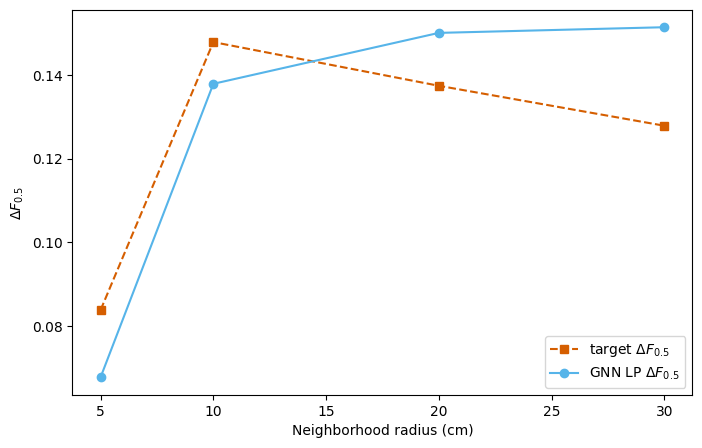

In [49]:
fig = plt.figure(figsize=(8, 5))

ax = fig.add_subplot(111)

ax.plot(r_ranges[:5], (np.array(target_F) - np.array(clue3D_F))[:5], '--s', label="target $\Delta F_{0.5}$", c="#D55E00")
ax.plot(r_ranges[:5], (np.array(model_reco_F) - np.array(clue3D_F))[:5], '-o', label="GNN LP $\Delta F_{0.5}$", c="#56B4E9")
# ax.plot(r_ranges[:5], (np.array(naive_reco_F) - np.array(clue3D_F))[:5], '-v', label="naive $\Delta F_{0.5}$", c="#E69F00")

# ax.axhline(max(np.array(naive_reco_F) - np.array(clue3D_F)), label="baseline", c="lightgray", linestyle="--")

ax.legend()
ax.set_xlabel("Neighborhood radius (cm)")
ax.set_ylabel("$\Delta F_{0.5}$")
# ax.set_ylim((-0.1, 0.1))

fig.savefig(f'export/{ds_name}-e10-graph-lp-radius-plot.png', dpi=300, bbox_inches='tight', transparent=True)
plt.show()

In [50]:
print("Reco", max(np.array(model_reco_F) - np.array(clue3D_F)))
# print("Naive", max(np.array(naive_reco_F) - np.array(clue3D_F)))
print("Target", max(np.array(target_F) - np.array(clue3D_F)))

Reco 0.15140615224425535
Target 0.1478511417336167


## Setup comparison:

Pairwise:
- mean clue3d_to_sim:	P: 0.994 R: 0.301 F: 0.652
- mean target_to_sim:	P: 0.992 R: 0.689 F: 0.892
- mean reco_to_sim:	    P: 0.659 R: 0.699 F: 0.642

Graph (node-pred):
- mean clue3d_to_sim:	P: 0.994 R: 0.301 F: 0.652
- mean target_to_sim:	P: 0.992 R: 0.688 F: 0.892
- mean reco_to_sim:	    P: 0.659 R: 0.699 F: 0.642

Graph (link-pred):
- mean clue3d_to_sim:	P: 0.994 R: 0.301 F: 0.652
- mean target_to_sim:	P: 0.992 R: 0.689 F: 0.892
- mean reco_to_sim:	P: 0.915 R: 0.329 F: 0.637


## Results

Using alpha=balance seems to converge faster (100 epochs rather than 200)
- maybe just sticking to 0.25? (works just fine)

Hyperparams
- (64, 128, noskip), alpha=balance, roc_auc = 0.9733
- (64, 128, 256fc, noskip, 200e), alpha=1-balance, roc_auc = 0.9771
- (64, 128, 256fc, noskip, 200e), alpha=balance, roc_auc = 0.981
- (64, 128, 256fc, noskip, 100e), alpha=0.25, roc_auc = 0.9796